In [ ]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import re 
from tqdm import tqdm
import seaborn as sns
from Bio import SeqIO
from Bio import SeqUtils
import numpy as np
import shutil

#set dir to project root
os.chdir("/workdir/hdd29/chloroplast_genome_evaluation")

In [2]:
tax_data = pd.read_csv("data/taxonomy_info.csv")

#find all entries with Arabidopsis thaliana in the organism column
at_data = tax_data[tax_data["Organism"] == "Arabidopsis thaliana"]

In [3]:
at_data

,ID,FileBasename,Organism,Taxonomy,Year,SequencingTech
2025,PV530470.1,PV5304701,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2025,Illumina
9721,OP484997.1,OP4849971,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2024,Illumina
9722,OP474144.1,OP4741441,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2024,Illumina
29888,NC_000932.1,NC0009321,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2023,Unknown
37188,CP096030.1,CP0960301,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2022,Illumina
41741,MZ323108.1,MZ3231081,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2021,Unknown
41753,MN603471.1,MN6034711,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2021,Illumina
45397,MK380721.1,MK3807211,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2020,Unknown
45398,MK380720.1,MK3807201,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2020,Unknown
45399,MK380719.1,MK3807191,Arabidopsis thaliana,Eukaryota; Viridiplantae; Streptophyta; Embryo...,2020,Unknown


In [19]:
#find at_data$ FileBasename + .fa in data/genomes and write to data/speciesWork/At/genomes
for index, row in at_data.iterrows():
    file_name = row["FileBasename"] + ".fa"
    src = os.path.join("data/genomes", file_name)
    dst_dir = "data/speciesWork/At/genomes"
    os.makedirs(dst_dir, exist_ok=True)
    dst = os.path.join(dst_dir, file_name)
    
    assert os.path.exists(src), f"File {src} does not exist"
    shutil.copy2(src, dst)

# Find FileBasename + .fa in data/genomes and create MFA
mfa_path = "data/speciesWork/At/genomes/combined.mfa"
os.makedirs(os.path.dirname(mfa_path), exist_ok=True)

with open(mfa_path, 'w') as mfa_out:
    for index, row in at_data.iterrows():
        file_name = row["FileBasename"] + ".fa"
        src = os.path.join("data/genomes", file_name)
        
        assert os.path.exists(src), f"File {src} does not exist"
        
        with open(src, 'r') as fa_in:
            mfa_out.write(fa_in.read())

print(f"MFA written to {mfa_path}")

MFA written to data/speciesWork/At/genomes/combined.mfa


#align using 
/programs/mafft/bin/mafft --auto --adjustdirection --thread 4 data/speciesWork/At/genomes/combined.mfa > data/speciesWork/At/panGenome.mfa



In [ ]:
def get_sites_from_alignment(aln_file, min_coverage=0.9):
    """Extract alignment sites, filtering by sample coverage"""
    aln = list(SeqIO.parse(aln_file, 'fasta'))
    aln_len = len(aln[0].seq)
    
    assert all(len(r.seq) == aln_len for r in aln), 'Sequences have different lengths'
    
    aln_dict = {r.id.split("_")[0]: list(str(r.seq).upper()) for r in aln}
    aln_df = pd.DataFrame(aln_dict).T
    
    basename = aln_file.split("/")[-1].split(".")[0]
    aln_df.columns = [f"{basename}_{i}" for i in range(aln_len)]
    
    # Remove sites with too many gaps
    aln_df = aln_df.loc[:, (aln_df == '-').mean() < (1 - min_coverage)]
    
    return aln_df

def encode_major_minor(aln_df):
    """Encode sites as 0=major allele, 1=minor allele, NaN=gap"""
    encoded = pd.DataFrame(index=aln_df.index)
    
    for col in tqdm(aln_df.columns):
        most_common = aln_df[col].mode()[0]
        encoded[col] = aln_df[col].apply(
            lambda x: 0 if x == most_common else (np.nan if x == "-" else 1)
        )
    
    return encoded

def encode_onehot(aln_df, alleles=['A', 'T', 'C', 'G']):
    """One-hot encode alleles at each site"""
    result = []
    
    for site in tqdm(aln_df.columns):
        for allele in alleles:
            encoded = (aln_df[site] == allele).astype(float)
            encoded[aln_df[site] == '-'] = np.nan
            result.append(encoded.rename(f"{site}_{allele}"))
    
    return pd.concat(result, axis=1)

100%|██████████| 216574/216574 [00:01<00:00, 134083.73it/s]


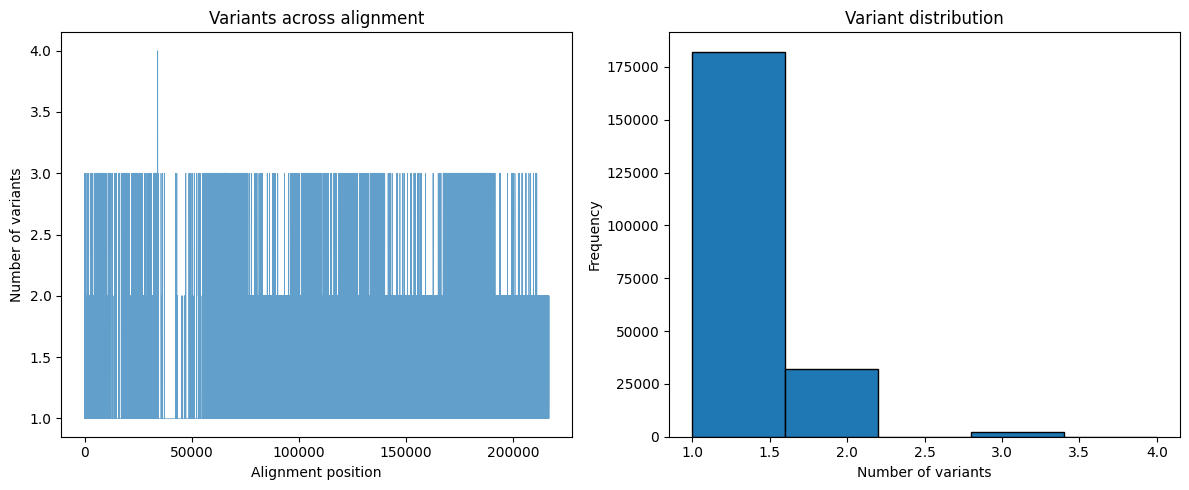

Total sites: 216574
Mean variants per site: 1.17
Sites with >1 variant: 34347


In [17]:
def count_variants_per_site(aln_file):
    """Count number of variants at each alignment position"""
    aln = list(SeqIO.parse(aln_file, 'fasta'))
    aln_len = len(aln[0].seq)
    
    assert all(len(r.seq) == aln_len for r in aln), 'Sequences have different lengths'
    
    # Build alignment matrix
    aln_matrix = np.array([list(str(r.seq).upper()) for r in aln])
    
    # Count unique non-gap alleles at each site
    variant_counts = []
    for i in tqdm(range(aln_len)):
        site = aln_matrix[:, i]
        non_gap = site[site != '-']
        n_variants = len(np.unique(non_gap)) if len(non_gap) > 0 else 0
        variant_counts.append(n_variants)
    
    return np.array(variant_counts)

# Count variants
variants = count_variants_per_site("data/speciesWork/At/panGenome.mfa")

# Plot distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(variants, linewidth=0.5, alpha=0.7)
plt.xlabel('Alignment position')
plt.ylabel('Number of variants')
plt.title('Variants across alignment')

plt.subplot(1, 2, 2)
plt.hist(variants, bins=max(variants)+1, edgecolor='black')
plt.xlabel('Number of variants')
plt.ylabel('Frequency')
plt.title('Variant distribution')

plt.tight_layout()
plt.savefig('data/speciesWork/At/variant_distribution.png', dpi=300)
plt.show()

print(f"Total sites: {len(variants)}")
print(f"Mean variants per site: {variants.mean():.2f}")
print(f"Sites with >1 variant: {(variants > 1).sum()}")

#annotate using the annotation script
grab the protein fastas 
mkdir data/speciesWork/At/proteinFastas
cp  data/speciesWork/At/annotationResults/*/*/*Protein.fasta  data/speciesWork/At/proteinFastas/

In [ ]:
import os
from Bio import SeqIO
from collections import defaultdict

# Dictionary to store sequences by protein name
proteins = defaultdict(list)

# Read all protein fasta files
fasta_dir = "data/speciesWork/At/proteinFastas/"
for fasta_file in os.listdir(fasta_dir):
    if not fasta_file.endswith(".fasta"):
        continue
    
    # Extract sample name (e.g., AP0004231fa from AP0004231fa.Protein.fasta)
    sample_name = fasta_file.replace("fa.Protein.fasta", "")
    
    # Parse sequences
    for record in SeqIO.parse(os.path.join(fasta_dir, fasta_file), "fasta"):
        # Extract protein name (e.g., rps12 from rps12_join{...})
        protein_name = record.id.split("_")[0]
        
        # Create new ID with sample name
        record.id = f"{sample_name}_{record.id}"
        record.description = ""
        
        proteins[protein_name].append(record)

# Write protein-specific fastas
out_dir = "data/speciesWork/At/proteinsByGene/"
os.makedirs(out_dir, exist_ok=True)

for protein_name, records in proteins.items():
    out_file = os.path.join(out_dir, f"{protein_name}.fasta")
    SeqIO.write(records, out_file, "fasta")
    print(f"Wrote {len(records)} sequences to {out_file}")

100%|██████████| 80/80 [00:00<00:00, 465.76it/s]


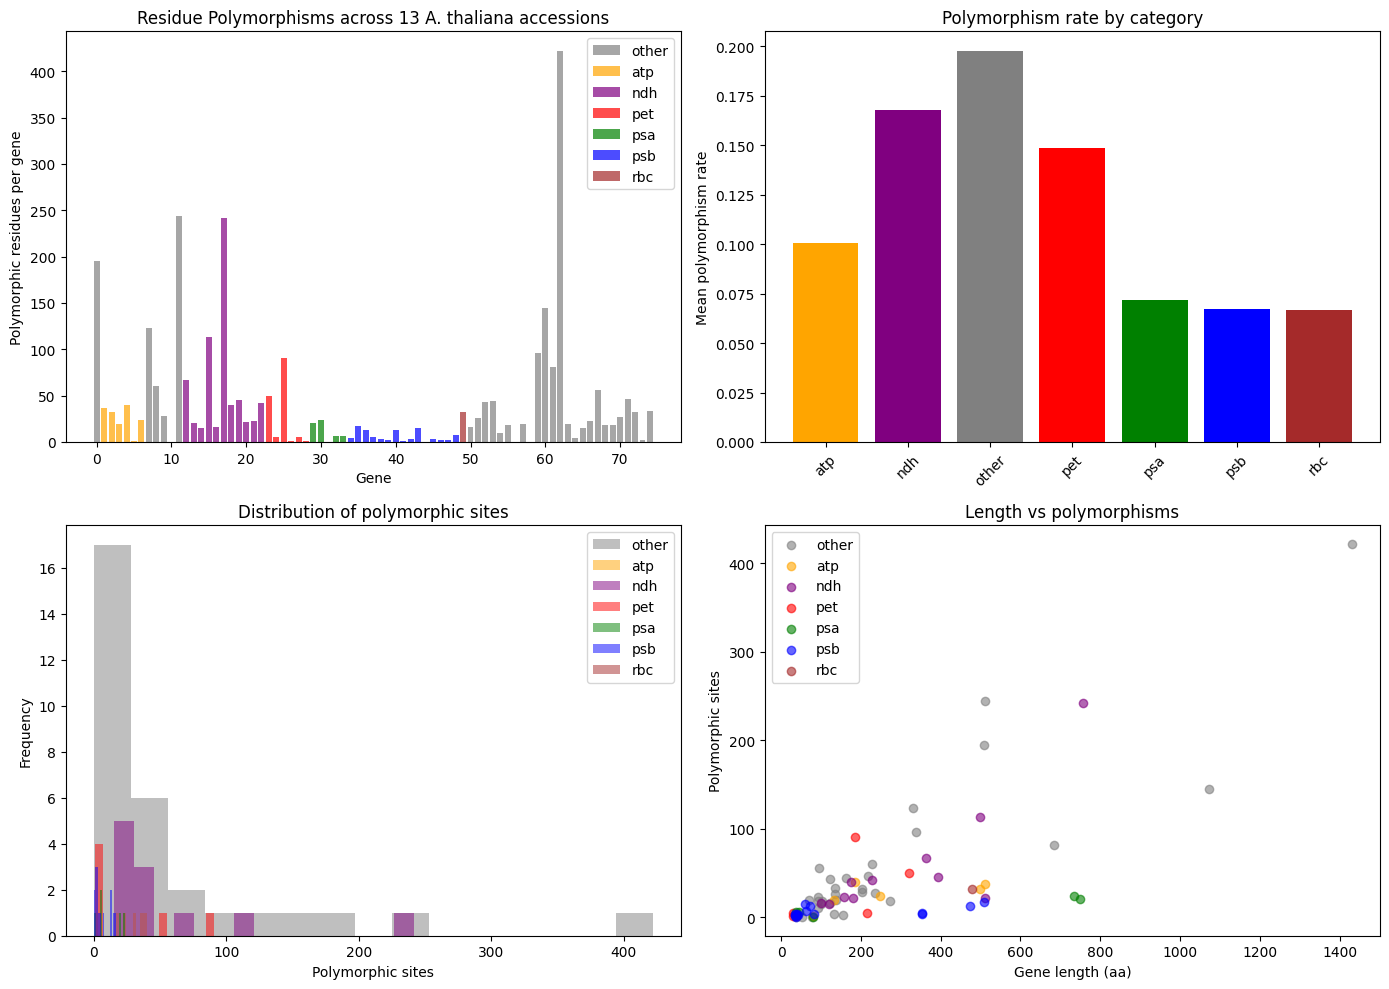


Total genes: 75
Mean polymorphic sites: 39.91
Mean polymorphism rate: 0.1454

By category:
          polymorphic_sites  poly_rate
category                              
atp               25.500000   0.100575
ndh               58.727273   0.168090
other             60.096774   0.197747
pet               25.500000   0.148592
psa               11.200000   0.071578
psb                6.000000   0.067028
rbc               32.000000   0.066806


In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from tqdm import tqdm

def count_polymorphisms_per_gene(aln_file):
    """Count polymorphic sites in an alignment"""
    aln = list(SeqIO.parse(aln_file, 'fasta'))
    aln_len = len(aln[0].seq)
    
    assert all(len(r.seq) == aln_len for r in aln), f'Sequences have different lengths in {aln_file}'
    
    aln_matrix = np.array([list(str(r.seq).upper()) for r in aln])
    
    # Count sites with >1 non-gap allele
    n_polymorphic = 0
    for i in range(aln_len):
        site = aln_matrix[:, i]
        non_gap = site[site != '-']
        if len(np.unique(non_gap)) > 1:
            n_polymorphic += 1
    
    return n_polymorphic, aln_len

def get_gene_category(gene_name):
    """Assign gene to functional category based on prefix"""
    prefixes = ['psb', 'psa', 'pet', 'atp', 'ndh', 'rbc']
    for prefix in prefixes:
        if gene_name.startswith(prefix):
            return prefix
    return 'other'

# Process all alignments
aln_dir = "data/speciesWork/At/alignedProteins/"
results = []

for aln_file in tqdm(sorted(os.listdir(aln_dir))):
    if not aln_file.endswith(".fasta"):
        continue

    if aln_file.startswith("ycf"):
        continue
    
    gene_name = aln_file.replace(".fasta", "")
    n_poly, aln_len = count_polymorphisms_per_gene(os.path.join(aln_dir, aln_file))
    poly_rate = n_poly / aln_len if aln_len > 0 else 0
    category = get_gene_category(gene_name)
    results.append({'gene': gene_name, 'polymorphic_sites': n_poly, 
                    'length': aln_len, 'poly_rate': poly_rate, 'category': category})



results_df = pd.DataFrame(results)

# Color mapping
colors = {'psb': 'blue', 'psa': 'green', 'pet': 'red', 
          'atp': 'orange', 'ndh': 'purple', 'rbc': 'brown', 'other': 'gray'}

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Polymorphic sites per gene
for category in results_df['category'].unique():
    mask = results_df['category'] == category
    axes[0, 0].bar(np.where(mask)[0], results_df[mask]['polymorphic_sites'], 
                   color=colors[category], label=category, alpha=0.7)
axes[0, 0].set_xlabel('Gene')
axes[0, 0].set_ylabel('Polymorphic residues per gene')
axes[0, 0].set_title('Residue Polymorphisms across 13 A. thaliana accessions')
axes[0, 0].legend()

# Polymorphism rate by category
category_means = results_df.groupby('category')['poly_rate'].mean()
axes[0, 1].bar(range(len(category_means)), category_means.values, 
               color=[colors[c] for c in category_means.index])
axes[0, 1].set_xticks(range(len(category_means)))
axes[0, 1].set_xticklabels(category_means.index, rotation=45)
axes[0, 1].set_ylabel('Mean polymorphism rate')
axes[0, 1].set_title('Polymorphism rate by category')

# Distribution by category
for category in results_df['category'].unique():
    data = results_df[results_df['category'] == category]['polymorphic_sites']
    axes[1, 0].hist(data, bins=15, alpha=0.5, label=category, color=colors[category])
axes[1, 0].set_xlabel('Polymorphic sites')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of polymorphic sites')
axes[1, 0].legend()

# Length vs polymorphisms
for category in results_df['category'].unique():
    mask = results_df['category'] == category
    axes[1, 1].scatter(results_df[mask]['length'], results_df[mask]['polymorphic_sites'], 
                      alpha=0.6, label=category, color=colors[category])
axes[1, 1].set_xlabel('Gene length (aa)')
axes[1, 1].set_ylabel('Polymorphic sites')
axes[1, 1].set_title('Length vs polymorphisms')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('data/speciesWork/At/gene_polymorphisms.png', dpi=300)
plt.show()

print(f"\nTotal genes: {len(results_df)}")
print(f"Mean polymorphic sites: {results_df['polymorphic_sites'].mean():.2f}")
print(f"Mean polymorphism rate: {results_df['poly_rate'].mean():.4f}")
print(f"\nBy category:")
print(results_df.groupby('category')[['polymorphic_sites', 'poly_rate']].mean())

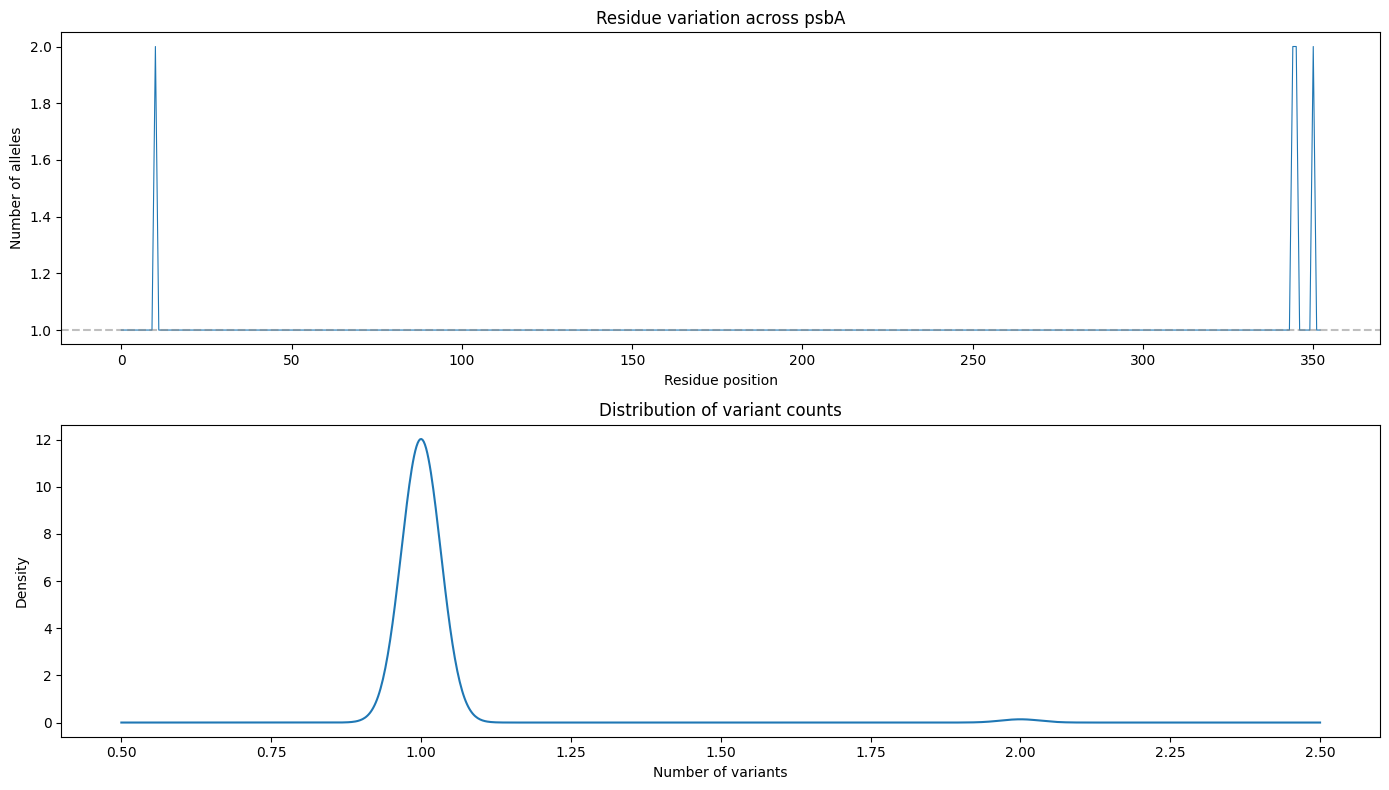

Total residues: 353
Variable sites: 4
Mean variants per site: 1.01


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

# Read psbA alignment
aln_file = "data/speciesWork/At/proteinsByGene/psbA.fasta"
aln = list(SeqIO.parse(aln_file, 'fasta'))
aln_len = len(aln[0].seq)

assert all(len(r.seq) == aln_len for r in aln), 'Sequences have different lengths'

# Build alignment matrix
aln_matrix = np.array([list(str(r.seq).upper()) for r in aln])

# Count variants per site
variants_per_site = []
for i in range(aln_len):
    site = aln_matrix[:, i]
    non_gap = site[site != '-']
    n_variants = len(np.unique(non_gap)) if len(non_gap) > 0 else 0
    variants_per_site.append(n_variants)

variants_per_site = np.array(variants_per_site)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Variants across protein
axes[0].plot(variants_per_site, linewidth=0.8)
axes[0].set_xlabel('Residue position')
axes[0].set_ylabel('Number of alleles')
axes[0].set_title('Residue variation across psbA')
axes[0].axhline(y=1, color='gray', linestyle='--', alpha=0.5)

# Distribution of variants
variant_counts = pd.Series(variants_per_site[variants_per_site > 0])
variant_counts.plot(kind='density', ax=axes[1])
axes[1].set_xlabel('Number of variants')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution of variant counts')

plt.tight_layout()
plt.savefig('data/speciesWork/At/psbA_residue_variation.png', dpi=300)
plt.show()

print(f"Total residues: {len(variants_per_site)}")
print(f"Variable sites: {(variants_per_site > 1).sum()}")
print(f"Mean variants per site: {variants_per_site.mean():.2f}")

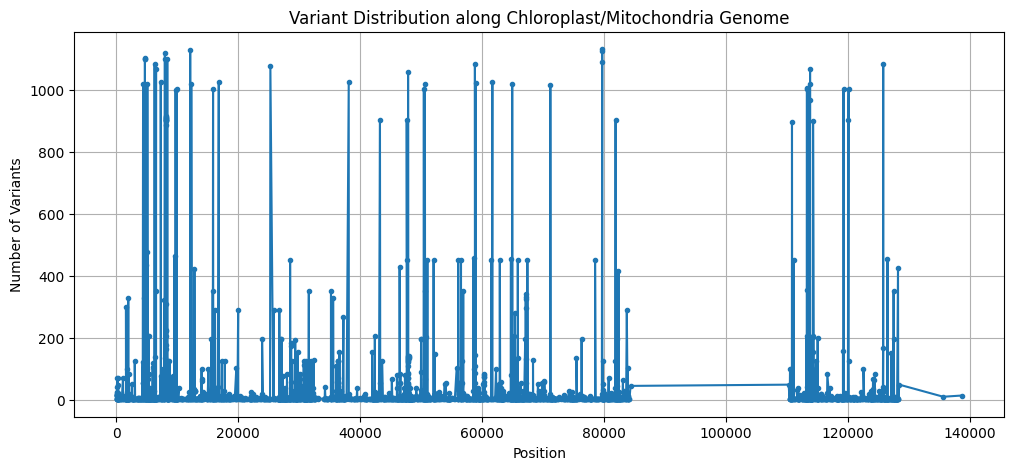

In [6]:
#this variant file has the  header 
#CHROM POS 10001	10002	10004	10005	9992
#so its the chromosome (C or M), position, and then the sample 
# so a row would be like C 82 A A A A A A A T A A A 
variant_file = 'data/chloroplast_mitochondria_variant_calls.txt'
#load variant file into pandas dataframe
variant_df = pd.read_csv(variant_file, sep='\t')
#and plot the variants along the position axis

#filter to only include CHROM == 'C'
c_variant_df = variant_df[variant_df['CHROM'] == 'chloroplast']

plt.figure(figsize=(12, 5))
positions = c_variant_df['POS']
num_variants = (c_variant_df.iloc[:, 2:] != c_variant_df.iloc[:, 2:].iloc[:, 0:1].values).sum(axis=1)
plt.plot(positions, num_variants, marker='o', linestyle='-', markersize=3)
plt.xlabel('Position')
plt.ylabel('Number of Variants')
plt.title('Variant Distribution along Chloroplast/Mitochondria Genome')
plt.grid()
plt.show()

In [9]:
# Codon table
CODON_TABLE = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

# Parse GBF file
gbf_file = 'data/speciesWork/At/gbfs/NC0009321fa.gbf'
record = SeqIO.read(gbf_file, 'genbank')
genome_seq = str(record.seq)

# Collect CDS features
cds_features = []
for feature in record.features:
    if feature.type == 'CDS':
        gene_name = feature.qualifiers.get('gene', ['unknown'])[0]
        product = feature.qualifiers.get('product', [''])[0]
        cds_features.append({
            'gene': gene_name,
            'product': product,
            'location': feature.location
        })

assert len(cds_features) > 0, "No CDS regions found"

# Check each variant
results = []
for _, variant in tqdm(c_variant_df.iterrows()):
    pos = variant['POS']
    
    # Get variant alleles (skip first 2 columns: CHROM, POS)
    alleles = variant.iloc[2:].values
    ref_allele = alleles[0]
    
    # Check if position is in any CDS
    for cds in cds_features:
        location = cds['location']
        
        # Check if position is in this CDS (1-based to 0-based)
        if (pos - 1) in location:
            # Extract CDS sequence
            cds_seq = str(location.extract(record.seq))
            
            # Find position within CDS
            pos_in_cds = None
            cumulative = 0
            for part in location.parts:
                part_len = len(part)
                if (pos - 1) in part:
                    pos_in_cds = cumulative + ((pos - 1) - int(part.start))
                    break
                cumulative += part_len
            
            assert pos_in_cds is not None, f"Position {pos} in CDS but not found in parts"
            
            # Determine codon position
            codon_start = (pos_in_cds // 3) * 3
            codon_pos_in_codon = pos_in_cds % 3
            ref_codon = cds_seq[codon_start:codon_start + 3]
            
            # Handle complement strand
            if location.strand == -1:
                complement = str.maketrans('ATCG', 'TAGC')
                ref_allele = ref_allele.translate(complement)
            
            # Check each sample for variants
            for i, allele in enumerate(alleles):
                if allele != ref_allele:
                    alt_allele = allele
                    if location.strand == -1:
                        alt_allele = alt_allele.translate(complement)
                    
                    # Create alternate codon
                    alt_codon = list(ref_codon)
                    alt_codon[codon_pos_in_codon] = alt_allele
                    alt_codon = ''.join(alt_codon)
                    
                    # Translate
                    ref_aa = CODON_TABLE.get(ref_codon.upper(), '?')
                    alt_aa = CODON_TABLE.get(alt_codon.upper(), '?')
                    
                    is_nonsynonymous = (ref_aa != alt_aa)
                    
                    results.append({
                        'position': pos,
                        'gene': cds['gene'],
                        'product': cds['product'],
                        'ref_codon': ref_codon.upper(),
                        'alt_codon': alt_codon.upper(),
                        'ref_aa': ref_aa,
                        'alt_aa': alt_aa,
                        'nonsynonymous': is_nonsynonymous
                    })
                    break  # Only need to record once per position
            break  # Found CDS for this position

results_df = pd.DataFrame(results)

# Summary
if len(results_df) > 0:
    total_cds_variants = len(results_df)
    nonsynonymous = results_df['nonsynonymous'].sum()
    print(f"Total variants in CDS: {total_cds_variants}")
    print(f"Non-synonymous variants: {nonsynonymous}")
    print(f"Synonymous variants: {total_cds_variants - nonsynonymous}")
    print(f"\nNon-synonymous variants by gene:")
    print(results_df[results_df['nonsynonymous']]['gene'].value_counts())
    print(f"\nNon-synonymous changes:")
    for _, row in results_df[results_df['nonsynonymous']].iterrows():
        print(f"  {row['gene']} pos {row['position']}: {row['ref_aa']} → {row['alt_aa']} ({row['ref_codon']} → {row['alt_codon']})")
    
    results_df.to_csv('variant_effects.csv', index=False)
else:
    print("No variants found in CDS regions")


0it [00:00, ?it/s]

2842it [00:00, 9714.46it/s]


Total variants in CDS: 875
Non-synonymous variants: 510
Synonymous variants: 365

Non-synonymous variants by gene:
gene
ycf1     97
rpoC2    45
ndhF     31
rpoB     23
matK     19
         ..
petD      1
rps18     1
rpl33     1
psaJ      1
ndhG      1
Name: count, Length: 62, dtype: int64

Non-synonymous changes:
  psbA pos 393: I → T (ATT → ACT)
  psbA pos 623: A → P (GCC → CCC)
  psbA pos 689: D → H (GAT → CAT)
  psbA pos 842: A → S (GCG → TCG)
  psbA pos 851: V → L (GTT → CTT)
  psbA pos 914: G → C (GGT → TGT)
  psbA pos 1121: N → H (AAC → CAC)
  psbA pos 1187: R → C (CGT → TGT)
  matK pos 2084: F → Y (TTC → TAC)
  matK pos 2190: Y → * (TAT → TAG)
  matK pos 2573: K → I (AAA → ATA)
  matK pos 2574: K → N (AAA → AAC)
  matK pos 2614: E → K (GAG → AAG)
  matK pos 2678: L → * (TTG → TAG)
  matK pos 2734: K → Q (AAG → CAG)
  matK pos 2776: F → I (TTT → ATT)
  matK pos 2785: I → V (ATT → GTT)
  matK pos 2806: H → N (CAC → AAC)
  matK pos 2977: F → I (TTT → ATT)
  matK pos 3013: N → H (AA

In [7]:
# Parse GBF file for CDS regions
gbf_file = 'data/speciesWork/At/gbfs/NC0009321fa.gbf'
cds_regions = []

for record in SeqIO.parse(gbf_file, 'genbank'):
    for feature in record.features:
        if feature.type == 'CDS':
            gene_name = feature.qualifiers.get('gene', ['unknown'])[0]
            product = feature.qualifiers.get('product', [''])[0]
            
            # Handle complement and join for position extraction
            for part in feature.location.parts:
                cds_regions.append({
                    'gene': gene_name,
                    'product': product,
                    'start': int(part.start),
                    'end': int(part.end),
                    'strand': part.strand
                })

cds_df = pd.DataFrame(cds_regions)
assert len(cds_df) > 0, "No CDS regions found in GBF file"

# Map variants to CDS regions
variants_in_cds = []
for _, variant in c_variant_df.iterrows():
    pos = variant['POS']
    for _, cds in cds_df.iterrows():
        if cds['start'] <= pos <= cds['end']:
            variants_in_cds.append({
                'position': pos,
                'gene': cds['gene'],
                'product': cds['product']
            })
            break

variants_in_cds_df = pd.DataFrame(variants_in_cds)

# Summary
total_variants = len(c_variant_df)
variants_in_cds_count = len(variants_in_cds_df)
print(f"Total chloroplast variants: {total_variants}")
print(f"Variants in CDS regions: {variants_in_cds_count}")
print(f"Percentage in CDS: {100 * variants_in_cds_count / total_variants:.1f}%")
print(f"\nVariants by gene:")
print(variants_in_cds_df['gene'].value_counts())


Total chloroplast variants: 2842
Variants in CDS regions: 877
Percentage in CDS: 30.9%

Variants by gene:
gene
ycf1     168
rpoC2     77
ndhF      47
rpoB      37
matK      33
        ... 
psbZ       1
psbJ       1
petN       1
rpl36      1
rps12      1
Name: count, Length: 69, dtype: int64
